In [1]:
%rm -rf /SimCLRv1-keras-tensorflow

!git clone https://github.com/mwdhont/SimCLRv1-keras-tensorflow.git

Cloning into 'SimCLRv1-keras-tensorflow'...
remote: Enumerating objects: 4916, done.
remote: Counting objects: 100% (4916/4916), done.
remote: Compressing objects: 100% (4878/4878), done.
remote: Total 4916 (delta 70), reused 4877 (delta 35), pack-reused 0
Receiving objects: 100% (4916/4916), 46.18 MiB | 17.84 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [2]:
%ls
%cd SimCLRv1-keras-tensorflow/
!pip install -r requirements.txt

sample_data/  SimCLRv1-keras-tensorflow/
/content/SimCLRv1-keras-tensorflow
     |████████████████████████████████| 7.7MB 6.5MB/s 
     |████████████████████████████████| 421.8MB 25kB/s 
     |████████████████████████████████| 26.3MB 116kB/s 
     |████████████████████████████████| 28.2MB 112kB/s 
     |████████████████████████████████| 6.9MB 46.6MB/s 
     |████████████████████████████████| 20.2MB 1.3MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
     |████████████████████████████████| 450kB 58.2MB/s 
     |████████████████████████████████| 3.9MB 52.6MB/s 
     |████████████████████████████████| 235kB 61.8MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=772e0a9f8cbee7a1f32ccc7d4d08c7283febfe758aadb21cc8dd693aea587220
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: xarray 0.15.1 has requirement

In [3]:
import numpy as np
import pickle
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16 

from evaluate_features import get_features, linear_classifier, tSNE_vis

# Load Dataframe

In [4]:
df = pd.read_pickle("data/df.pickle")
df.head()

ModuleNotFoundError: ignored

                                filename class_label    class_one_hot
0   data/processed/plastic/plastic80.jpg     plastic  [0, 0, 0, 0, 1]
1  data/processed/plastic/plastic381.jpg     plastic  [0, 0, 0, 0, 1]
2  data/processed/plastic/plastic169.jpg     plastic  [0, 0, 0, 0, 1]
3  data/processed/plastic/plastic354.jpg     plastic  [0, 0, 0, 0, 1]
4  data/processed/plastic/plastic185.jpg     plastic  [0, 0, 0, 0, 1]

In [5]:
class_labels = ["cardboard", "glass", "metal", "paper", "plastic"]
num_classes = len(df['class_one_hot'][0])

print("# of training instances:", len(df.index), "\n")
for label in class_labels:
    print(f"# of '{label}' training instances: {(df.class_label == label).sum()}")

# of training instances: 2390 

# of 'cardboard' training instances: 403
# of 'glass' training instances: 501
# of 'metal' training instances: 410
# of 'paper' training instances: 594
# of 'plastic' training instances: 482


In [6]:
df_train, df_val_test = train_test_split(df, test_size=0.30, random_state=42, shuffle=True)
df_val, df_test = train_test_split(df_val_test, test_size=0.50, random_state=42, shuffle=True)

print("# of training instances:", len(df_train.index), "\n")
for label in class_labels:
    print(f"# of '{label}' training instances: {(df_train.class_label == label).sum()}")
    
print()
print("# of validation instances:", len(df_val.index), "\n")
for label in class_labels:
    print(f"# of '{label}' training instances: {(df_val.class_label == label).sum()}")

print()
print("# of test instances:", len(df_test.index), "\n")
for label in class_labels:
    print(f"# of '{label}' training instances: {(df_test.class_label == label).sum()}")
    
dfs = {
    "train": df_train,
    "val": df_val,
    "test": df_test
}

# of training instances: 1673 

# of 'cardboard' training instances: 299
# of 'glass' training instances: 358
# of 'metal' training instances: 286
# of 'paper' training instances: 405
# of 'plastic' training instances: 325

# of validation instances: 358 

# of 'cardboard' training instances: 47
# of 'glass' training instances: 84
# of 'metal' training instances: 51
# of 'paper' training instances: 100
# of 'plastic' training instances: 76

# of test instances: 359 

# of 'cardboard' training instances: 57
# of 'glass' training instances: 59
# of 'metal' training instances: 73
# of 'paper' training instances: 89
# of 'plastic' training instances: 81


In [7]:
# Img size
size = 80
height_img = size
width_img = size

input_shape = (height_img, width_img, 3)

# Load pretrained VGG16 & Feature evaluation

In [8]:
params_vgg16 = {'weights': "imagenet", 
                'include_top': False, 
                'input_shape': input_shape, 
                'pooling': None}

# Design model
base_model = VGG16(**params_vgg16)
base_model.summary()

58892288/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
______________________________________________________________

In [9]:
feat_dim = 2 * 2 * 512

# Build SimCLR-Model

In [10]:
from DataGeneratorSimCLR import DataGeneratorSimCLR as DataGenerator
from SimCLR import SimCLR

Using TensorFlow backend.


### Properties

In [11]:
batch_size = 32
# Projection_head
num_layers_ph = 2
feat_dims_ph = [2048, 128]
num_of_unfrozen_layers = 1 #Note: with 1, all weights of the base_model are still frozen (last layer is max_pool)
save_path = 'models/trashnet'

In [12]:
SimCLR = SimCLR(
        base_model = base_model,
        input_shape = input_shape,
        batch_size = batch_size,
        feat_dim = feat_dim,
        feat_dims_ph = feat_dims_ph,
        num_of_unfrozen_layers = num_of_unfrozen_layers,
        save_path = save_path
    )

In [13]:
params_generator = {'batch_size': batch_size,
                    'shuffle' : True,
                    'width':width_img,
                    'height': height_img,
                    'VGG': True
                   }

# Generators
data_train = DataGenerator(df_train.reset_index(drop=True), **params_generator)
data_val = DataGenerator(df_val.reset_index(drop=True), subset = "val", **params_generator) #val keeps the unity values on the same random places ~42
data_test = DataGenerator(df_test.reset_index(drop=True), subset = "test", **params_generator) #test keeps the unity values on the diagonal

In [14]:
y_predict_test_before = SimCLR.predict(data_test)

# SimCLR - Round 1: Only Projection head

## Training SimCLR

In [15]:
SimCLR.train(data_train, data_val, epochs = 5)

Train for 53 steps, validate for 12 steps
Epoch 1/5
52/53 [============================>.] - ETA: 1s - loss: 389.5823
Epoch 00001: val_loss improved from inf to 339.24903, saving model to models/trashnet/SimCLR/SimCLR_07_25_09h_27.h5
53/53 [==============================] - 75s 1s/step - loss: 388.6704 - val_loss: 339.2490
Epoch 2/5
52/53 [============================>.] - ETA: 0s - loss: 296.5550
Epoch 00002: val_loss improved from 339.24903 to 252.58843, saving model to models/trashnet/SimCLR/SimCLR_07_25_09h_27.h5
53/53 [==============================] - 49s 919ms/step - loss: 295.7576 - val_loss: 252.5884
Epoch 3/5
52/53 [============================>.] - ETA: 0s - loss: 216.1633
Epoch 00003: val_loss improved from 252.58843 to 179.10358, saving model to models/trashnet/SimCLR/SimCLR_07_25_09h_27.h5
53/53 [==============================] - 49s 933ms/step - loss: 215.4898 - val_loss: 179.1036
Epoch 4/5
52/53 [============================>.] - ETA: 0s - loss: 149.2019
Epoch 00004: va

In [16]:
y_predict_test_after = SimCLR.predict(data_test)

## SimCLR-output check

In [17]:
print(f"Random guess accuracy: {round(1/(2*batch_size),4)}")

print(f"accuracy - test - before: {np.round(np.sum(data_test[0][1] * y_predict_test_before[:batch_size])/(2*batch_size),2)}")
print(f"accuracy - test - after: {np.round(np.sum(data_test[0][1] * y_predict_test_after[:batch_size])/(2*batch_size),2)}")

Random guess accuracy: 0.0156
accuracy - test - before: 0.6
accuracy - test - after: 0.93


In [18]:
print("y_predict_test_before")
for i in range(min(batch_size, 15)):
    print(np.round(y_predict_test_before[i][i],2), end=" | ")
print("\n")    
print("y_predict_test_after")
for i in range(min(batch_size, 15)):
    print(np.round(y_predict_test_after[i][i],2), end=" | ")
print("\n") 
print("y_predict_test_after - Second diagonal")
for i in range(min(batch_size, 15)):
    print(np.round(y_predict_test_after[i + 2 * batch_size][i],2), end=" | ")
print("\n")    

y_predict_test_before
0.85 | 0.52 | 0.51 | 0.23 | 0.81 | 0.78 | 0.81 | 0.73 | 0.56 | 0.58 | 0.62 | 0.81 | 0.36 | 0.88 | 0.74 | 

y_predict_test_after
0.99 | 0.99 | 0.97 | 0.99 | 0.99 | 0.99 | 0.99 | 0.93 | 0.99 | 0.99 | 0.97 | 0.95 | 0.05 | 0.66 | 0.98 | 

y_predict_test_after - Second diagonal
0.97 | 0.99 | 0.98 | 0.95 | 0.98 | 0.99 | 0.96 | 0.72 | 0.98 | 0.96 | 0.74 | 0.99 | 0.98 | 0.92 | 0.89 | 



## Feature Evaluation

Note that this evaluation corresponds with the unaltered pretrained weights

In [19]:
fractions = [1.0, 0.2, 0.05]

### Logistic regression evaluation

In [20]:
features_train, y_train, feats = get_features(base_model, df_train, class_labels)
features_test, y_test, feats = get_features(base_model, df_test, class_labels)
np.count_nonzero(features_train[0])

280

In [21]:
# Training logistic regression classifier on 3 fractions of the data
# Optimal regularization is determined from a 5-fold cross-validation
for fraction in fractions:
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    linear_classifier(features_train, y_train, features_test, y_test, class_labels, fraction = fraction)

    ==== 100.0% of the training data used ==== 

Accuracy on test: 0.79 

              precision    recall  f1-score   support

   cardboard       0.87      0.84      0.86        57
       glass       0.64      0.78      0.70        59
       metal       0.83      0.71      0.76        73
       paper       0.80      0.89      0.84        89
     plastic       0.81      0.70      0.75        81

    accuracy                           0.79       359
   macro avg       0.79      0.79      0.78       359
weighted avg       0.79      0.79      0.79       359

    ==== 20.0% of the training data used ==== 

Accuracy on test: 0.7 

              precision    recall  f1-score   support

   cardboard       0.90      0.79      0.84        57
       glass       0.55      0.69      0.61        59
       metal       0.69      0.47      0.56        73
       paper       0.70      0.83      0.76        89
     plastic       0.71      0.69      0.70        81

    accuracy                           

### Fine tuned model

In [22]:
batch_size_classifier = 32
params_generator_classifier = {'max_width':width_img,
                            'max_height': height_img,
                            'num_classes': num_classes,
                            'VGG': True
                            }
params_training_classifier = {'1.0':{
                                "reg_dense" : 0.005,
                                "reg_out" : 0.005,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 5e-5],
                                "epochs" : [5, 5, 15, 10]
                                },
                              '0.2':{
                                "reg_dense" : 0.075,
                                "reg_out" : 0.01,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 5e-5],
                                "epochs" : [5, 5, 20, 15]
                              },
                              '0.05':{
                                "reg_dense" : 0.01,
                                "reg_out" : 0.02,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 1e-5],
                                "epochs" : [5, 5, 20, 15]
                              }                              
                            }

In [23]:
for fraction in fractions:
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    SimCLR.train_NL_and_evaluate(dfs = dfs,
                                batch_size = batch_size_classifier,
                                params_generator = params_generator_classifier,
                                fraction = fraction,
                                class_labels = class_labels,
                                reg_dense = params_training_classifier[str(fraction)]["reg_dense"],
                                reg_out = params_training_classifier[str(fraction)]["reg_out"],
                                nums_of_unfrozen_layers = params_training_classifier[str(fraction)]["nums_of_unfrozen_layers"],
                                lrs = params_training_classifier[str(fraction)]["lrs"],
                                epochs = params_training_classifier[str(fraction)]["epochs"],
                                verbose_epoch = 0,
                                verbose_cycle = 0
                                )

    ==== 100.0% of the training data used ==== 

Best result from attempt 5
              precision    recall  f1-score   support

   cardboard       0.94      0.89      0.92        57
       glass       0.84      0.81      0.83        59
       metal       0.82      0.85      0.83        73
       paper       0.86      0.93      0.89        89
     plastic       0.81      0.75      0.78        81

    accuracy                           0.85       359
   macro avg       0.85      0.85      0.85       359
weighted avg       0.85      0.85      0.85       359

    ==== 20.0% of the training data used ==== 

Best result from attempt 1
              precision    recall  f1-score   support

   cardboard       0.93      0.88      0.90        57
       glass       0.81      0.73      0.77        59
       metal       0.81      0.85      0.83        73
       paper       0.83      0.97      0.89        89
     plastic       0.85      0.74      0.79        81

    accuracy                      

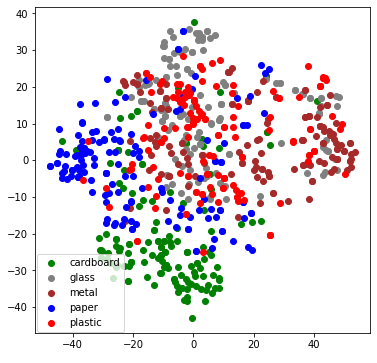

In [24]:
tSNE_vis(df_train, features_train, class_labels)

# SimCLR - Round 2: Unfreeze last convolutional layer

## Training SimCLR

In [25]:
#Unfreeze
SimCLR.unfreeze_and_train(data_train, data_val, num_of_unfrozen_layers = 2, r = 2, lr = 1e-5, epochs = 5)   

trainable parameters: 6.82 M.
non-trainable parameters: 12.35 M.
Train for 53 steps, validate for 12 steps
Epoch 1/5
52/53 [============================>.] - ETA: 1s - loss: 72.2229
Epoch 00001: val_loss improved from inf to 69.59197, saving model to models/trashnet/SimCLR/SimCLR_07_25_09h_45.h5
53/53 [==============================] - 79s 1s/step - loss: 72.1778 - val_loss: 69.5920
Epoch 2/5
52/53 [============================>.] - ETA: 0s - loss: 68.1055
Epoch 00002: val_loss improved from 69.59197 to 66.40417, saving model to models/trashnet/SimCLR/SimCLR_07_25_09h_45.h5
53/53 [==============================] - 54s 1s/step - loss: 68.0773 - val_loss: 66.4042
Epoch 3/5
52/53 [============================>.] - ETA: 0s - loss: 65.0160
Epoch 00003: val_loss improved from 66.40417 to 63.39869, saving model to models/trashnet/SimCLR/SimCLR_07_25_09h_45.h5
53/53 [==============================] - 53s 1s/step - loss: 64.9913 - val_loss: 63.3987
Epoch 4/5
52/53 [============================>

## Feature Evaluation

### Logisitic regression

In [26]:
base_model = SimCLR.base_model
fractions = [1.0, 0.2, 0.05]

In [27]:
features_train, y_train, feats = get_features(base_model, df_train, class_labels)
features_test, y_test, feats = get_features(base_model, df_test, class_labels)
np.count_nonzero(features_train[0])

785

In [28]:
# Training logistic regression classifier on 3 fractions of the data
# Optimal regularization is determined from a 5-fold cross-validation
for fraction in fractions:
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    linear_classifier(features_train, y_train, features_test, y_test, class_labels, fraction = fraction)

    ==== 100.0% of the training data used ==== 

Accuracy on test: 0.84 

              precision    recall  f1-score   support

   cardboard       0.84      0.93      0.88        57
       glass       0.75      0.80      0.77        59
       metal       0.85      0.82      0.83        73
       paper       0.90      0.91      0.91        89
     plastic       0.85      0.75      0.80        81

    accuracy                           0.84       359
   macro avg       0.84      0.84      0.84       359
weighted avg       0.84      0.84      0.84       359

    ==== 20.0% of the training data used ==== 

Accuracy on test: 0.81 

              precision    recall  f1-score   support

   cardboard       0.84      0.95      0.89        57
       glass       0.69      0.76      0.73        59
       metal       0.82      0.75      0.79        73
       paper       0.84      0.92      0.88        89
     plastic       0.86      0.69      0.77        81

    accuracy                          

### Fine tuned model

In [29]:
batch_size_classifier = 32
params_generator_classifier = {'max_width':width_img,
                            'max_height': height_img,
                            'num_classes': num_classes,
                            'VGG': True
                            }
params_training_classifier = {'1.0':{
                                "reg_dense" : 0.005,
                                "reg_out" : 0.005,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 5e-5],
                                "epochs" : [5, 5, 15, 10]
                                },
                              '0.2':{
                                "reg_dense" : 0.075,
                                "reg_out" : 0.01,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 5e-5],
                                "epochs" : [5, 5, 20, 15]
                              },
                              '0.05':{
                                "reg_dense" : 0.01,
                                "reg_out" : 0.02,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 1e-5],
                                "epochs" : [5, 5, 20, 15]
                              }                              
                            }

In [30]:
for fraction in fractions:    
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    SimCLR.train_NL_and_evaluate(dfs = dfs,
                                batch_size = batch_size_classifier,
                                params_generator = params_generator_classifier,
                                fraction = fraction,
                                class_labels = class_labels,
                                reg_dense = params_training_classifier[str(fraction)]["reg_dense"],
                                reg_out = params_training_classifier[str(fraction)]["reg_out"],
                                nums_of_unfrozen_layers = params_training_classifier[str(fraction)]["nums_of_unfrozen_layers"],
                                lrs = params_training_classifier[str(fraction)]["lrs"],
                                epochs = params_training_classifier[str(fraction)]["epochs"],
                                verbose_epoch = 0,
                                verbose_cycle = 0
                                )

    ==== 100.0% of the training data used ==== 

Learning diverged, stopped.
Best result from attempt 4
              precision    recall  f1-score   support

   cardboard       0.96      0.91      0.94        57
       glass       0.82      0.80      0.81        59
       metal       0.81      0.90      0.86        73
       paper       0.85      0.93      0.89        89
     plastic       0.86      0.73      0.79        81

    accuracy                           0.86       359
   macro avg       0.86      0.85      0.86       359
weighted avg       0.86      0.86      0.85       359

    ==== 20.0% of the training data used ==== 

Learning diverged, stopped.
Best result from attempt 1
              precision    recall  f1-score   support

   cardboard       0.93      0.91      0.92        57
       glass       0.83      0.76      0.80        59
       metal       0.82      0.93      0.87        73
       paper       0.87      0.93      0.90        89
     plastic       0.85      0.74

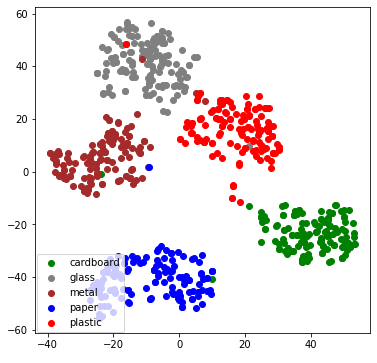

In [31]:
tSNE_vis(df_train, features_train, class_labels)

# SimCLR - Round 3: Unfreeze 2 last convolutional layer

## Training SimCLR

In [32]:
#Unfreeze
SimCLR.unfreeze_and_train(data_train, data_val, num_of_unfrozen_layers = 3, r = 3, lr = 5e-6, epochs = 5)   

trainable parameters: 9.18 M.
non-trainable parameters: 10.0 M.
Train for 53 steps, validate for 12 steps
Epoch 1/5
52/53 [============================>.] - ETA: 1s - loss: 58.1905
Epoch 00001: val_loss improved from inf to 56.99666, saving model to models/trashnet/SimCLR/SimCLR_07_25_10h_04.h5
53/53 [==============================] - 86s 2s/step - loss: 58.1696 - val_loss: 56.9967
Epoch 2/5
52/53 [============================>.] - ETA: 0s - loss: 56.4327
Epoch 00002: val_loss improved from 56.99666 to 55.72707, saving model to models/trashnet/SimCLR/SimCLR_07_25_10h_04.h5
53/53 [==============================] - 59s 1s/step - loss: 56.4221 - val_loss: 55.7271
Epoch 3/5
52/53 [============================>.] - ETA: 0s - loss: 55.2348
Epoch 00003: val_loss improved from 55.72707 to 54.56079, saving model to models/trashnet/SimCLR/SimCLR_07_25_10h_04.h5
53/53 [==============================] - 59s 1s/step - loss: 55.2233 - val_loss: 54.5608
Epoch 4/5
52/53 [============================>.

In [33]:
y_predict_test_after = SimCLR.predict(data_test)

## Feature Evaluation

In [34]:
base_model = SimCLR.base_model

In [35]:
features_train, y_train, feats = get_features(base_model, df_train, class_labels)
features_test, y_test, feats = get_features(base_model, df_test, class_labels)
np.count_nonzero(features_train[0])

846

In [36]:
# Training logistic regression classifier on 3 fractions of the data
# Optimal regularization is determined from a 5-fold cross-validation
fractions = [1.0, 0.2, 0.05]
for fraction in fractions:
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    linear_classifier(features_train, y_train, features_test, y_test, class_labels, fraction = fraction)

    ==== 100.0% of the training data used ==== 

Accuracy on test: 0.84 

              precision    recall  f1-score   support

   cardboard       0.87      0.93      0.90        57
       glass       0.75      0.80      0.77        59
       metal       0.83      0.88      0.85        73
       paper       0.91      0.88      0.89        89
     plastic       0.83      0.74      0.78        81

    accuracy                           0.84       359
   macro avg       0.84      0.84      0.84       359
weighted avg       0.84      0.84      0.84       359

    ==== 20.0% of the training data used ==== 

Accuracy on test: 0.83 

              precision    recall  f1-score   support

   cardboard       0.87      0.93      0.90        57
       glass       0.73      0.80      0.76        59
       metal       0.80      0.82      0.81        73
       paper       0.88      0.88      0.88        89
     plastic       0.84      0.73      0.78        81

    accuracy                          

### Fine tuned model

In [37]:
batch_size_classifier = 32
params_generator_classifier = {'max_width':width_img,
                            'max_height': height_img,
                            'num_classes': num_classes,
                            'VGG': True
                        }

In [38]:
for fraction in fractions:
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    SimCLR.train_NL_and_evaluate(dfs = dfs,
                                batch_size = batch_size_classifier,
                                params_generator = params_generator_classifier,
                                fraction = fraction,
                                class_labels = class_labels,
                                reg_dense = 0.005,
                                reg_out = 0.003,
                                nums_of_unfrozen_layers = [5, 5, 6, 7],
                                lrs = [1e-3, 1e-4, 5e-5, 1e-5],
                                epochs = [5, 5, 15, 10],
                                verbose_epoch = 0,
                                verbose_cycle = 0
                                )

    ==== 100.0% of the training data used ==== 

Best result from attempt 3
              precision    recall  f1-score   support

   cardboard       0.96      0.91      0.94        57
       glass       0.81      0.85      0.83        59
       metal       0.81      0.89      0.85        73
       paper       0.87      0.92      0.90        89
     plastic       0.87      0.74      0.80        81

    accuracy                           0.86       359
   macro avg       0.86      0.86      0.86       359
weighted avg       0.86      0.86      0.86       359

    ==== 20.0% of the training data used ==== 

Best result from attempt 3
              precision    recall  f1-score   support

   cardboard       0.88      0.91      0.90        57
       glass       0.83      0.83      0.83        59
       metal       0.82      0.85      0.83        73
       paper       0.91      0.92      0.92        89
     plastic       0.87      0.80      0.83        81

    accuracy                      

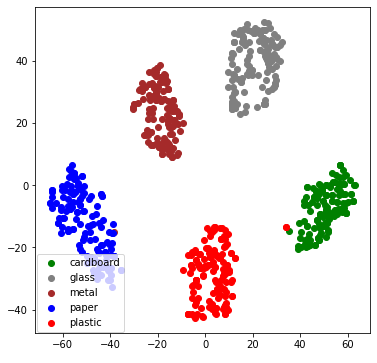

In [39]:
tSNE_vis(df_train, features_train, class_labels)

# SimCLR - Round 4: Unfreeze 3 last convolutional layer

In [40]:
y_predict_test_before = y_predict_test_after

## Training SimCLR

In [41]:
#Unfreeze
SimCLR.unfreeze_and_train(data_train, 
                          data_val, 
                          num_of_unfrozen_layers = 4, 
                          r = 4, 
                          lr = 1e-6, 
                          epochs = 5)  

trainable parameters: 11.54 M.
non-trainable parameters: 7.64 M.
Train for 53 steps, validate for 12 steps
Epoch 1/5
52/53 [============================>.] - ETA: 1s - loss: 53.7285
Epoch 00001: val_loss improved from inf to 52.67540, saving model to models/trashnet/SimCLR/SimCLR_07_25_10h_23.h5
53/53 [==============================] - 90s 2s/step - loss: 53.7145 - val_loss: 52.6754
Epoch 2/5
52/53 [============================>.] - ETA: 1s - loss: 52.6048
Epoch 00002: val_loss improved from 52.67540 to 52.33002, saving model to models/trashnet/SimCLR/SimCLR_07_25_10h_23.h5
53/53 [==============================] - 63s 1s/step - loss: 52.6012 - val_loss: 52.3300
Epoch 3/5
52/53 [============================>.] - ETA: 1s - loss: 52.3287
Epoch 00003: val_loss improved from 52.33002 to 52.18499, saving model to models/trashnet/SimCLR/SimCLR_07_25_10h_23.h5
53/53 [==============================] - 63s 1s/step - loss: 52.3261 - val_loss: 52.1850
Epoch 4/5
52/53 [============================>

In [42]:
y_predict_test_after = SimCLR.predict(data_test)

## Feature Evaluation

### Logistic Regression

In [43]:
base_model = SimCLR.base_model

In [44]:
features_train, y_train, feats = get_features(base_model, df_train, class_labels)
features_test, y_test, feats = get_features(base_model, df_test, class_labels)
np.count_nonzero(features_train[0])

1103

In [45]:
# Training logistic regression classifier on 3 fractions of the data
# Optimal regularization is determined from a 5-fold cross-validation
fractions = [1.0, 0.2, 0.05]
for fraction in fractions:
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    linear_classifier(features_train, y_train, features_test, y_test, class_labels, fraction = fraction)

    ==== 100.0% of the training data used ==== 

Accuracy on test: 0.83 

              precision    recall  f1-score   support

   cardboard       0.90      0.82      0.86        57
       glass       0.80      0.80      0.80        59
       metal       0.79      0.90      0.84        73
       paper       0.84      0.89      0.86        89
     plastic       0.83      0.72      0.77        81

    accuracy                           0.83       359
   macro avg       0.83      0.83      0.83       359
weighted avg       0.83      0.83      0.83       359

    ==== 20.0% of the training data used ==== 

Accuracy on test: 0.82 

              precision    recall  f1-score   support

   cardboard       0.92      0.84      0.88        57
       glass       0.77      0.80      0.78        59
       metal       0.79      0.85      0.82        73
       paper       0.81      0.89      0.85        89
     plastic       0.83      0.73      0.78        81

    accuracy                          

### Fine tuned model

In [46]:
batch_size_classifier = 32
params_generator_classifier = {'max_width':width_img,
                            'max_height': height_img,
                            'num_classes': num_classes,
                            'VGG': True
                            }
params_training_classifier = {'1.0':{
                                "reg_dense" : 0.005,
                                "reg_out" : 0.005,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 5e-5],
                                "epochs" : [5, 5, 15, 10]
                                },
                              '0.2':{
                                "reg_dense" : 0.075,
                                "reg_out" : 0.01,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 5e-5],
                                "epochs" : [5, 5, 20, 15]
                              },
                              '0.05':{
                                "reg_dense" : 0.01,
                                "reg_out" : 0.02,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 1e-5],
                                "epochs" : [5, 5, 20, 15]
                              }                              
                            }

In [47]:
for fraction in fractions:    
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    SimCLR.train_NL_and_evaluate(dfs = dfs,
                                batch_size = batch_size_classifier,
                                params_generator = params_generator_classifier,
                                fraction = fraction,
                                class_labels = class_labels,
                                reg_dense = params_training_classifier[str(fraction)]["reg_dense"],
                                reg_out = params_training_classifier[str(fraction)]["reg_out"],
                                nums_of_unfrozen_layers = params_training_classifier[str(fraction)]["nums_of_unfrozen_layers"],
                                lrs = params_training_classifier[str(fraction)]["lrs"],
                                epochs = params_training_classifier[str(fraction)]["epochs"],
                                verbose_epoch = 0,
                                verbose_cycle = 0
                                )

    ==== 100.0% of the training data used ==== 

Best result from attempt 3
              precision    recall  f1-score   support

   cardboard       0.96      0.91      0.94        57
       glass       0.85      0.88      0.87        59
       metal       0.81      0.89      0.85        73
       paper       0.90      0.94      0.92        89
     plastic       0.92      0.80      0.86        81

    accuracy                           0.89       359
   macro avg       0.89      0.89      0.89       359
weighted avg       0.89      0.89      0.89       359

    ==== 20.0% of the training data used ==== 

Best result from attempt 1
              precision    recall  f1-score   support

   cardboard       0.90      0.95      0.92        57
       glass       0.83      0.83      0.83        59
       metal       0.81      0.86      0.83        73
       paper       0.92      0.92      0.92        89
     plastic       0.90      0.81      0.86        81

    accuracy                      

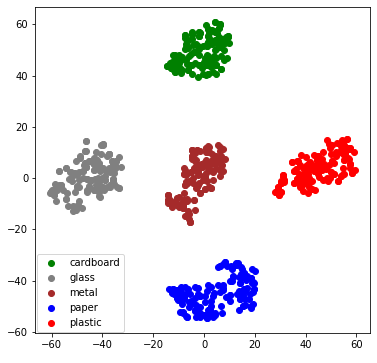

In [48]:
tSNE_vis(df_train, features_train, class_labels)